In [1]:
!gdown "19vWwsNfrU5W3GMJrb2RLOoZbVAFRQ6P7"

Downloading...
From: https://drive.google.com/uc?id=19vWwsNfrU5W3GMJrb2RLOoZbVAFRQ6P7
To: /content/data.zip
100% 67.0M/67.0M [00:01<00:00, 62.7MB/s]


In [2]:
!unzip data.zip

Streaming output truncated to the last 5000 lines.
  inflating: data/lineStrokes/l01/l01-076/l01-076z-02.xml  
  inflating: data/lineStrokes/l01/l01-076/l01-076z-03.xml  
  inflating: data/lineStrokes/l01/l01-076/l01-076z-04.xml  
   creating: data/lineStrokes/l01/l01-083/
  inflating: data/lineStrokes/l01/l01-083/l01-083z-01.xml  
  inflating: data/lineStrokes/l01/l01-083/l01-083z-02.xml  
  inflating: data/lineStrokes/l01/l01-083/l01-083z-03.xml  
  inflating: data/lineStrokes/l01/l01-083/l01-083z-04.xml  
  inflating: data/lineStrokes/l01/l01-083/l01-083z-05.xml  
   creating: data/lineStrokes/l01/l01-091/
  inflating: data/lineStrokes/l01/l01-091/l01-091z-01.xml  
  inflating: data/lineStrokes/l01/l01-091/l01-091z-02.xml  
  inflating: data/lineStrokes/l01/l01-091/l01-091z-03.xml  
  inflating: data/lineStrokes/l01/l01-091/l01-091z-04.xml  
  inflating: data/lineStrokes/l01/l01-091/l01-091z-05.xml  
  inflating: data/lineStrokes/l01/l01-091/l01-091z-06.xml  
  inflating: data/lineS

In [4]:
!pip install svgwrite

     |████████████████████████████████| 67 kB 3.3 MB/s 


In [1]:
import os
import pickle
import random
import xml.etree.ElementTree as ET

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import svgwrite
from IPython.display import SVG, display

import torch
from torch import nn, optim
import torch.nn.functional as F

import time
from ipywidgets import FloatProgress

use_cuda = False
use_cuda = torch.cuda.is_available()

# Network configuration
n_batch = 20
sequence_length = 300
hidden_size = 256
n_layers = 3
n_gaussians = 10
gradient_threshold = 10
dropout = 0.2

# Small number to avoid log(0) issue
eps = float(np.finfo(np.float32).eps)

# The network could use the extra space :)
torch.cuda.empty_cache()

In [2]:
def get_bounds(data, factor):
    min_x = 0
    max_x = 0
    min_y = 0
    max_y = 0

    abs_x = 0
    abs_y = 0
    for i in range(len(data)):
        x = float(data[i, 0]) / factor
        y = float(data[i, 1]) / factor
        abs_x += x
        abs_y += y
        min_x = min(min_x, abs_x)
        min_y = min(min_y, abs_y)
        max_x = max(max_x, abs_x)
        max_y = max(max_y, abs_y)

    return (min_x, max_x, min_y, max_y)

# old version, where each path is entire stroke (smaller svg size, but
# have to keep same color)


def draw_strokes(data, factor=10, svg_filename='sample.svg'):
    min_x, max_x, min_y, max_y = get_bounds(data, factor)
    dims = (50 + max_x - min_x, 50 + max_y - min_y)

    dwg = svgwrite.Drawing(svg_filename, size=dims)
    dwg.add(dwg.rect(insert=(0, 0), size=dims, fill='white'))

    lift_pen = 1

    abs_x = 25 - min_x
    abs_y = 25 - min_y
    p = "M%s,%s " % (abs_x, abs_y)

    command = "m"

    for i in range(len(data)):
        if (lift_pen == 1):
            command = "m"
        elif (command != "l"):
            command = "l"
        else:
            command = ""
        x = float(data[i, 0]) / factor
        y = float(data[i, 1]) / factor
        lift_pen = data[i, 2]
        p += command + str(x) + "," + str(y) + " "

    the_color = "black"
    stroke_width = 1

    dwg.add(dwg.path(p).stroke(the_color, stroke_width).fill("none"))

    dwg.save()
    display(SVG(dwg.tostring()))


def draw_strokes_eos_weighted(
        stroke,
        param,
        factor=10,
        svg_filename='sample_eos.svg'):
    c_data_eos = np.zeros((len(stroke), 3))
    for i in range(len(param)):
        # make color gray scale, darker = more likely to eos
        c_data_eos[i, :] = (1 - param[i][6][0]) * 225
    draw_strokes_custom_color(
        stroke,
        factor=factor,
        svg_filename=svg_filename,
        color_data=c_data_eos,
        stroke_width=3)


def draw_strokes_random_color(
        stroke,
        factor=10,
        svg_filename='sample_random_color.svg',
        per_stroke_mode=True):
    c_data = np.array(np.random.rand(len(stroke), 3) * 240, dtype=np.uint8)
    if per_stroke_mode:
        switch_color = False
        for i in range(len(stroke)):
            if switch_color == False and i > 0:
                c_data[i] = c_data[i - 1]
            if stroke[i, 2] < 1:  # same strike
                switch_color = False
            else:
                switch_color = True
    draw_strokes_custom_color(
        stroke,
        factor=factor,
        svg_filename=svg_filename,
        color_data=c_data,
        stroke_width=2)


def draw_strokes_custom_color(
        data,
        factor=10,
        svg_filename='test.svg',
        color_data=None,
        stroke_width=1):
    min_x, max_x, min_y, max_y = get_bounds(data, factor)
    dims = (50 + max_x - min_x, 50 + max_y - min_y)

    dwg = svgwrite.Drawing(svg_filename, size=dims)
    dwg.add(dwg.rect(insert=(0, 0), size=dims, fill='white'))

    lift_pen = 1
    abs_x = 25 - min_x
    abs_y = 25 - min_y

    for i in range(len(data)):

        x = float(data[i, 0]) / factor
        y = float(data[i, 1]) / factor

        prev_x = abs_x
        prev_y = abs_y

        abs_x += x
        abs_y += y

        if (lift_pen == 1):
            p = "M " + str(abs_x) + "," + str(abs_y) + " "
        else:
            p = "M +" + str(prev_x) + "," + str(prev_y) + \
                " L " + str(abs_x) + "," + str(abs_y) + " "

        lift_pen = data[i, 2]

        the_color = "black"

        if (color_data is not None):
            the_color = "rgb(" + str(int(color_data[i, 0])) + "," + str(
                int(color_data[i, 1])) + "," + str(int(color_data[i, 2])) + ")"

        dwg.add(dwg.path(p).stroke(the_color, stroke_width).fill(the_color))
    dwg.save()
    display(SVG(dwg.tostring()))


class DataLoader():
    def __init__(
            self,
            batch_size=50,
            seq_length=300,
            scale_factor=10,
            limit=500):
        self.data_dir = "./data"
        self.batch_size = batch_size
        self.seq_length = seq_length
        self.scale_factor = scale_factor  # divide data by this factor
        self.limit = limit  # removes large noisy gaps in the data

        data_file = os.path.join(self.data_dir, "strokes_training_data.cpkl")
        raw_data_dir = self.data_dir + "/lineStrokes"

        if not (os.path.exists(data_file)):
            print("creating training data pkl file from raw source")
            self.preprocess(raw_data_dir, data_file)

        self.load_preprocessed(data_file)
        self.reset_batch_pointer()

    def preprocess(self, data_dir, data_file):
        # create data file from raw xml files from iam handwriting source.

        # build the list of xml files
        filelist = []
        # Set the directory you want to start from
        rootDir = data_dir
        for dirName, subdirList, fileList in os.walk(rootDir):
            #print('Found directory: %s' % dirName)
            for fname in fileList:
                #print('\t%s' % fname)
                filelist.append(dirName + "/" + fname)

        # function to read each individual xml file
        def getStrokes(filename):
            tree = ET.parse(filename)
            root = tree.getroot()

            result = []

            x_offset = 1e20
            y_offset = 1e20
            y_height = 0
            for i in range(1, 4):
                x_offset = min(x_offset, float(root[0][i].attrib['x']))
                y_offset = min(y_offset, float(root[0][i].attrib['y']))
                y_height = max(y_height, float(root[0][i].attrib['y']))
            y_height -= y_offset
            x_offset -= 100
            y_offset -= 100

            for stroke in root[1].findall('Stroke'):
                points = []
                for point in stroke.findall('Point'):
                    points.append(
                        [float(point.attrib['x']) - x_offset, float(point.attrib['y']) - y_offset])
                result.append(points)

            return result

        # converts a list of arrays into a 2d numpy int16 array
        def convert_stroke_to_array(stroke):

            n_point = 0
            for i in range(len(stroke)):
                n_point += len(stroke[i])
            stroke_data = np.zeros((n_point, 3), dtype=np.int16)

            prev_x = 0
            prev_y = 0
            counter = 0

            for j in range(len(stroke)):
                for k in range(len(stroke[j])):
                    stroke_data[counter, 0] = int(stroke[j][k][0]) - prev_x
                    stroke_data[counter, 1] = int(stroke[j][k][1]) - prev_y
                    prev_x = int(stroke[j][k][0])
                    prev_y = int(stroke[j][k][1])
                    stroke_data[counter, 2] = 0
                    if (k == (len(stroke[j]) - 1)):  # end of stroke
                        stroke_data[counter, 2] = 1
                    counter += 1
            return stroke_data

        # build stroke database of every xml file inside iam database
        strokes = []
        for i in range(len(filelist)):
            if (filelist[i][-3:] == 'xml'):
                print('processing ' + filelist[i])
                strokes.append(
                    convert_stroke_to_array(
                        getStrokes(
                            filelist[i])))

        f = open(data_file, "wb")
        pickle.dump(strokes, f, protocol=2)
        f.close()

    def load_preprocessed(self, data_file):
        f = open(data_file, "rb")
        self.raw_data = pickle.load(f)
        f.close()

        # goes thru the list, and only keeps the text entries that have more
        # than seq_length points
        self.data = []
        self.valid_data = []
        counter = 0

        # every 1 in 20 (5%) will be used for validation data
        cur_data_counter = 0
        for data in self.raw_data:
            if len(data) > (self.seq_length + 2):
                # removes large gaps from the data
                data = np.minimum(data, self.limit)
                data = np.maximum(data, -self.limit)
                data = np.array(data, dtype=np.float32)
                data[:, 0:2] /= self.scale_factor
                cur_data_counter = cur_data_counter + 1
                if cur_data_counter % 20 == 0:
                    self.valid_data.append(data)
                else:
                    self.data.append(data)
                    # number of equiv batches this datapoint is worth
                    counter += int(len(data) / ((self.seq_length + 2)))

        print("train data: {}, valid data: {}".format(
            len(self.data), len(self.valid_data)))
        # minus 1, since we want the ydata to be a shifted version of x data
        self.num_batches = int(counter / self.batch_size)

    def validation_data(self):
        # returns validation data
        x_batch = []
        y_batch = []
        for i in range(self.batch_size):
            data = self.valid_data[i % len(self.valid_data)]
            idx = 0
            x_batch.append(np.copy(data[idx:idx + self.seq_length]))
            y_batch.append(np.copy(data[idx + 1:idx + self.seq_length + 1]))
        return x_batch, y_batch

    def next_batch(self):
        # returns a randomised, seq_length sized portion of the training data
        x_batch = []
        y_batch = []
        for i in range(self.batch_size):
            data = self.data[self.pointer]
            # number of equiv batches this datapoint is worth
            n_batch = int(len(data) / ((self.seq_length + 2)))
            idx = random.randint(0, len(data) - self.seq_length - 2)
            x_batch.append(np.copy(data[idx:idx + self.seq_length]))
            y_batch.append(np.copy(data[idx + 1:idx + self.seq_length + 1]))
            # adjust sampling probability.
            if random.random() < (1.0 / float(n_batch)):
                # if this is a long datapoint, sample this data more with
                # higher probability
                self.tick_batch_pointer()
        return x_batch, y_batch

    def tick_batch_pointer(self):
        self.pointer += 1
        if (self.pointer >= len(self.data)):
            self.pointer = 0

    def reset_batch_pointer(self):
        self.pointer = 0


In [3]:
# Creating the model

class HandwritingGenerationModel(nn.Module):
    def __init__(self, hidden_size = 256, n_layers = 3, n_gaussians = 10, dropout = 0):
        super(HandwritingGenerationModel, self).__init__()
        
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.n_gaussians = n_gaussians
        
        self.lstm = nn.LSTM(input_size = 3, hidden_size = hidden_size, num_layers = n_layers, dropout = dropout)
        
        self.z_e = nn.Linear(hidden_size, 1)
        self.z_pi = nn.Linear(hidden_size, n_gaussians)
        self.z_mu1 = nn.Linear(hidden_size, n_gaussians)
        self.z_mu2 = nn.Linear(hidden_size, n_gaussians)
        self.z_sigma1 = nn.Linear(hidden_size, n_gaussians)
        self.z_sigma2 = nn.Linear(hidden_size, n_gaussians)
        self.z_rho = nn.Linear(hidden_size, n_gaussians)
        
    def forward(self, x, hidden = None):
        # number of batches
        n_batch = x.shape[0]
        
        # Computing the LSTM cells block
        out, hidden = self.lstm(x, hidden) 
        # print("out shape ", out.shape) # torch.Size([sequence_length, batch, hidden_size])

        es = self.z_e(out)
        # print("es shape ", es.shape) # -> torch.Size([sequence_length, batch, 1])
        es = 1 / (1 + torch.exp(es))
        # print("es shape", es.shape) # -> torch.Size([sequence_length, batch, 1])

        pis = self.z_pi(out)
        # print("pis shape ", pis.shape) # -> torch.Size([sequence_length, batch, n_gaussians])
        pis = torch.softmax(pis, 2)
        # print(pi.shape) # -> torch.Size([sequence_length, batch, n_gaussians])

        mu1s = self.z_mu1(out)
        mu2s = self.z_mu2(out)
        # print("mu shape :  ", mu1s.shape) # -> torch.Size([sequence_length, batch, n_gaussians])

        sigma1s = self.z_sigma1(out)
        sigma2s = self.z_sigma2(out)
        # print("sigmas shape ", sigma1s.shape) # -> torch.Size([sequence_length, batch, n_gaussians])
        sigma1s = torch.exp(sigma1s)
        sigma2s = torch.exp(sigma2s)
        # print(sigma1.shape) # -> torch.Size([sequence_length, batch, n_gaussians])

        rhos = self.z_rho(out)
        rhos = torch.tanh(rhos)
        # print("rhos shape ", rhos.shape) # -> torch.Size([sequence_length, batch, n_gaussians])

        es = es.squeeze(2) 
        # print("es shape ", es.shape) # -> torch.Size([sequence_length, batch])

        
        return es, pis, mu1s, mu2s, sigma1s, sigma2s, rhos
    
            
    def generate_sample(self, mu1, mu2, sigma1, sigma2, rho):
        mean = [mu1, mu2]
        cov = [[sigma1 ** 2, rho * sigma1 * sigma2], [rho * sigma1 * sigma2, sigma2 ** 2]]
        
        x = np.float32(np.random.multivariate_normal(mean, cov, 1))
        return torch.from_numpy(x)
        
        
    def generate_sequence(self, x0, sequence_length = 100):
        sequence = x0
        
        # A fun little widget
        print("Generating sequence ...")
        f = FloatProgress(min=0, max=sequence_length)
        display(f)
        
        for i in range(sequence_length):
            es, pis, mu1s, mu2s, sigma1s, sigma2s, rhos = self.forward(sequence)
            
            # Selecting a mixture 
            pi_idx = np.random.choice(range(self.n_gaussians), p=pis[-1, 0, :].detach().cpu().numpy())
            
            # taking last parameters from sequence corresponding to chosen gaussian
            mu1 = mu1s[-1, :, pi_idx].item()
            mu2 = mu2s[-1, :, pi_idx].item()
            sigma1 = sigma1s[-1, :, pi_idx].item()
            sigma2 = sigma2s[-1, :, pi_idx].item()
            rho = rhos[-1, :, pi_idx].item()
            
            prediction = self.generate_sample(mu1, mu2, sigma1, sigma2, rho)
            eos = torch.distributions.bernoulli.Bernoulli(torch.tensor([es[-1, :].item()])).sample()
            
            sample = torch.zeros_like(x0) # torch.Size([1, 1, 3])
            sample[0, 0, 0] = prediction[0, 0]
            sample[0, 0, 1] = prediction[0, 1]
            sample[0, 0, 2] = eos
            
            sequence = torch.cat((sequence, sample), 0) # torch.Size([sequence_length, 1, 3])
            
            f.value += 1
        
        return sequence.squeeze(1).detach().cpu().numpy()
                     
    

In [4]:
def gaussianMixture(y, pis, mu1s, mu2s, sigma1s, sigma2s, rhos):
    n_mixtures = pis.size(2)
    
    # Takes x1 and repeats it over the number of gaussian mixtures
    x1 = y[:,:, 0].repeat(n_mixtures, 1, 1).permute(1, 2, 0) 
    # print("x1 shape ", x1.shape) # -> torch.Size([sequence_length, batch, n_gaussians])
    
    # first term of Z (eq 25)
    x1norm = ((x1 - mu1s) ** 2) / (sigma1s ** 2 )
    # print("x1norm shape ", x1.shape) # -> torch.Size([sequence_length, batch, n_gaussians])
    
    x2 = y[:,:, 1].repeat(n_mixtures, 1, 1).permute(1, 2, 0)  
    # print("x2 shape ", x2.shape) # -> torch.Size([sequence_length, batch, n_gaussians])
    
    # second term of Z (eq 25)
    x2norm = ((x2 - mu2s) ** 2) / (sigma2s ** 2 )
    # print("x2norm shape ", x2.shape) # -> torch.Size([sequence_length, batch, n_gaussians])
    
    # third term of Z (eq 25)
    coxnorm = 2 * rhos * (x1 - mu1s) * (x2 - mu2s) / (sigma1s * sigma2s) 
    
    # Computing Z (eq 25)
    Z = x1norm + x2norm - coxnorm
    
    # Gaussian bivariate (eq 24)
    N = torch.exp(-Z / (2 * (1 - rhos ** 2))) / (2 * np.pi * sigma1s * sigma2s * (1 - rhos ** 2) ** 0.5) 
    # print("N shape ", N.shape) # -> torch.Size([sequence_length, batch, n_gaussians]) 
    
    # Pr is the result of eq 23 without the eos part
    Pr = pis * N 
    # print("Pr shape ", Pr.shape) # -> torch.Size([sequence_length, batch, n_gaussians])   
    Pr = torch.sum(Pr, dim=2) 
    # print("Pr shape ", Pr.shape) # -> torch.Size([sequence_length, batch])   
    
    if use_cuda:
        Pr = Pr.cuda()
    
    return Pr
    
    

In [5]:
def loss_fn(Pr, y, es):
    loss1 = - torch.log(Pr + eps) # -> torch.Size([sequence_length, batch])    
    bernouilli = torch.zeros_like(es) # -> torch.Size([sequence_length, batch])
    
    bernouilli = y[:, :, 2] * es + (1 - y[:, :, 2]) * (1 - es)
    
    loss2 = - torch.log(bernouilli + eps)
    loss = loss1 + loss2 
    # print("loss shape", loss.shape) # -> torch.Size([sequence_length, batch])  
    loss = torch.sum(loss, 0) 
    # print("loss shape", loss.shape) # -> torch.Size([batch]) 
    
    return torch.mean(loss);
    
    

In [6]:
def train_network(model, epochs = 5, generate = True):
    data_loader = DataLoader(n_batch, sequence_length, 20) # 20 = datascale
    
    optimizer = optim.Adam(model.parameters(), lr=0.005)
    
    if use_cuda:
        model = model.cuda()
        
    # Arrays to plot loss over time
    time_batch = []
    time_epoch = [0]
    loss_batch = []
    loss_epoch = []
    
    start = time.time()
    
    for epoch in range(epochs):
        data_loader.reset_batch_pointer()
        
        
        for batch in range(data_loader.num_batches):
            
            
            x, y = data_loader.next_batch()
            x = np.float32(np.array(x)) # -> (n_batch, sequence_length, 3)
            y = np.float32(np.array(y)) # -> (n_batch, sequence_length, 3)

            x = torch.from_numpy(x).permute(1, 0, 2) # torch.Size([sequence_length, n_batch, 3])
            y = torch.from_numpy(y).permute(1, 0, 2) # torch.Size([sequence_length, n_batch, 3])
            
            if use_cuda:
                x = x.cuda()
                y = y.cuda()
            
            # Forward pass
            es, pis, mu1s, mu2s, sigma1s, sigma2s, rhos = model.forward(x)
            
            # Calculate probability density and loss
            Pr = gaussianMixture(y, pis, mu1s, mu2s, sigma1s, sigma2s, rhos)
            loss = loss_fn(Pr,y, es)
            
            # Back propagation
            optimizer.zero_grad()
            loss.backward()
            
            # Gradient cliping
            torch.nn.utils.clip_grad_norm_(model.parameters(), gradient_threshold)
            optimizer.step()
            
            # Useful infos
            if batch % 100 == 0:
                print("Epoch : ", epoch, " - step ", batch, "/", data_loader.num_batches, " - loss ", loss.item(), " in ", time.time() - start)
                start = time.time()
            
                if generate and batch % 500 == 0:
                    x0 = torch.Tensor([0,0,1]).view(1,1,3)

                    if use_cuda:
                        x0 = x0.cuda()

                    sequence = model.generate_sequence(x0, sequence_length = 300)
                    draw_strokes_random_color(sequence, factor=0.5)
                    
                    
            # Save loss per batch
            time_batch.append(epoch + batch / data_loader.num_batches)
            loss_batch.append(loss.item())
        
        # Save loss per epoch
        time_epoch.append(epoch + 1)
        loss_epoch.append(sum(loss_batch[epoch * data_loader.num_batches : (epoch + 1)*data_loader.num_batches-1]) / data_loader.num_batches)
        
        # Save model after each epoch
        torch.save(model.state_dict(), "./models/prediction_model.pt")
        
    # Plot loss 
    plt.plot(time_batch, loss_batch)
    plt.plot(time_epoch, [loss_batch[0]] + loss_epoch, color="orange", linewidth=5)
    plt.xlabel("Epoch", fontsize=15)
    plt.ylabel("Loss", fontsize=15)
    plt.show()
        
    return model, time_batch, loss_batch, time_epoch, [loss_batch[0]] + loss_epoch

train data: 11035, valid data: 580
Epoch :  0  - step  0 / 911  - loss  1233.5325927734375  in  0.07464146614074707
Generating sequence ...


FloatProgress(value=0.0, max=300.0)

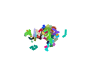

Epoch :  0  - step  100 / 911  - loss  321.10284423828125  in  7.324291229248047
Epoch :  0  - step  200 / 911  - loss  158.07371520996094  in  3.313105344772339
Epoch :  0  - step  300 / 911  - loss  114.19953918457031  in  3.3167688846588135
Epoch :  0  - step  400 / 911  - loss  161.15069580078125  in  3.343017578125
Epoch :  0  - step  500 / 911  - loss  109.79585266113281  in  3.3189499378204346
Generating sequence ...


FloatProgress(value=0.0, max=300.0)

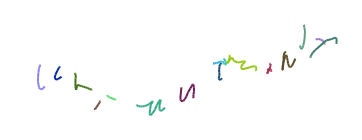

Epoch :  0  - step  600 / 911  - loss  216.7534637451172  in  5.823876142501831
Epoch :  0  - step  700 / 911  - loss  57.794593811035156  in  3.357065439224243
Epoch :  0  - step  800 / 911  - loss  104.15166473388672  in  3.373687982559204
Epoch :  0  - step  900 / 911  - loss  232.70359802246094  in  3.3776557445526123
Epoch :  1  - step  0 / 911  - loss  282.4167785644531  in  0.39208459854125977
Generating sequence ...


FloatProgress(value=0.0, max=300.0)

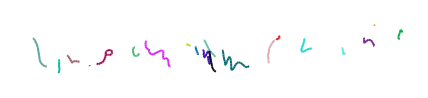

Epoch :  1  - step  100 / 911  - loss  23.180805206298828  in  5.9386608600616455
Epoch :  1  - step  200 / 911  - loss  186.3102264404297  in  3.6091251373291016
Epoch :  1  - step  300 / 911  - loss  -29.907135009765625  in  3.834822177886963
Epoch :  1  - step  400 / 911  - loss  27.450973510742188  in  3.395159959793091
Epoch :  1  - step  500 / 911  - loss  49.78788757324219  in  3.4029743671417236
Generating sequence ...


FloatProgress(value=0.0, max=300.0)

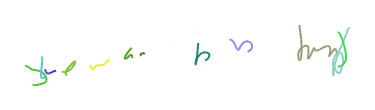

Epoch :  1  - step  600 / 911  - loss  107.09624481201172  in  6.711541414260864
Epoch :  1  - step  700 / 911  - loss  -71.74459075927734  in  3.4134888648986816
Epoch :  1  - step  800 / 911  - loss  31.616825103759766  in  3.427124500274658
Epoch :  1  - step  900 / 911  - loss  -8.296374320983887  in  3.4191486835479736
Epoch :  2  - step  0 / 911  - loss  244.99876403808594  in  0.3908355236053467
Generating sequence ...


FloatProgress(value=0.0, max=300.0)

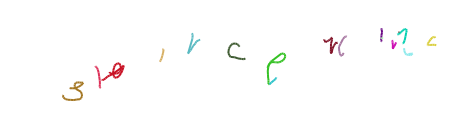

Epoch :  2  - step  100 / 911  - loss  115.7358627319336  in  6.201659679412842
Epoch :  2  - step  200 / 911  - loss  122.7900390625  in  3.444368600845337
Epoch :  2  - step  300 / 911  - loss  -11.926508903503418  in  3.448387384414673
Epoch :  2  - step  400 / 911  - loss  165.48977661132812  in  3.460556745529175
Epoch :  2  - step  500 / 911  - loss  60.96541976928711  in  3.4739980697631836
Generating sequence ...


FloatProgress(value=0.0, max=300.0)

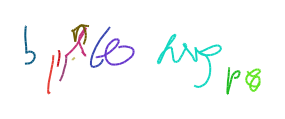

Epoch :  2  - step  600 / 911  - loss  22.0795841217041  in  6.331294059753418
Epoch :  2  - step  700 / 911  - loss  -10.47598934173584  in  3.4752891063690186
Epoch :  2  - step  800 / 911  - loss  -22.87660026550293  in  3.4856319427490234
Epoch :  2  - step  900 / 911  - loss  -8.326385498046875  in  3.5099053382873535
Epoch :  3  - step  0 / 911  - loss  238.71714782714844  in  0.39679765701293945
Generating sequence ...


FloatProgress(value=0.0, max=300.0)

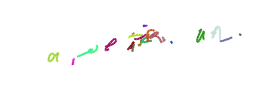

Epoch :  3  - step  100 / 911  - loss  -73.6331787109375  in  6.460046291351318
Epoch :  3  - step  200 / 911  - loss  92.73657989501953  in  3.508358955383301
Epoch :  3  - step  300 / 911  - loss  -115.57109832763672  in  3.5110747814178467
Epoch :  3  - step  400 / 911  - loss  -78.96165466308594  in  3.519995927810669
Epoch :  3  - step  500 / 911  - loss  40.874420166015625  in  3.5274362564086914
Generating sequence ...


FloatProgress(value=0.0, max=300.0)

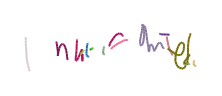

Epoch :  3  - step  600 / 911  - loss  51.999603271484375  in  6.573900461196899
Epoch :  3  - step  700 / 911  - loss  -62.43425369262695  in  3.54282546043396
Epoch :  3  - step  800 / 911  - loss  75.27245330810547  in  3.546619176864624
Epoch :  3  - step  900 / 911  - loss  88.16564178466797  in  3.548393964767456
Epoch :  4  - step  0 / 911  - loss  264.6880798339844  in  0.402026891708374
Generating sequence ...


FloatProgress(value=0.0, max=300.0)

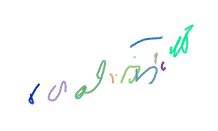

Epoch :  4  - step  100 / 911  - loss  -53.60072708129883  in  6.532058954238892
Epoch :  4  - step  200 / 911  - loss  -79.29821014404297  in  3.5617871284484863
Epoch :  4  - step  300 / 911  - loss  19.400434494018555  in  3.559375762939453
Epoch :  4  - step  400 / 911  - loss  39.64022445678711  in  3.5603604316711426
Epoch :  4  - step  500 / 911  - loss  -53.87714767456055  in  3.560256242752075
Generating sequence ...


FloatProgress(value=0.0, max=300.0)

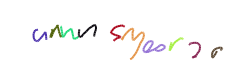

Epoch :  4  - step  600 / 911  - loss  -0.10794372856616974  in  6.636205673217773
Epoch :  4  - step  700 / 911  - loss  -36.86622619628906  in  3.5527050495147705
Epoch :  4  - step  800 / 911  - loss  -47.11603546142578  in  3.555558919906616
Epoch :  4  - step  900 / 911  - loss  76.69884490966797  in  3.546459197998047
Epoch :  5  - step  0 / 911  - loss  202.7257537841797  in  0.40267443656921387
Generating sequence ...


FloatProgress(value=0.0, max=300.0)

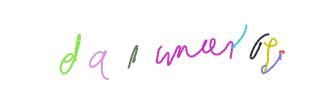

Epoch :  5  - step  100 / 911  - loss  112.25066375732422  in  6.713340520858765
Epoch :  5  - step  200 / 911  - loss  -85.09813690185547  in  3.545830488204956
Epoch :  5  - step  300 / 911  - loss  -41.9524040222168  in  3.5371663570404053
Epoch :  5  - step  400 / 911  - loss  -26.9630126953125  in  3.540733575820923
Epoch :  5  - step  500 / 911  - loss  -125.01702117919922  in  3.5442442893981934
Generating sequence ...


FloatProgress(value=0.0, max=300.0)

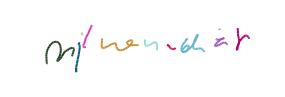

Epoch :  5  - step  600 / 911  - loss  -4.552948474884033  in  6.732227802276611
Epoch :  5  - step  700 / 911  - loss  -64.69192504882812  in  3.53277587890625
Epoch :  5  - step  800 / 911  - loss  -69.4264144897461  in  3.5420022010803223
Epoch :  5  - step  900 / 911  - loss  -47.6998176574707  in  3.5391671657562256
Epoch :  6  - step  0 / 911  - loss  197.0239715576172  in  0.40242648124694824
Generating sequence ...


FloatProgress(value=0.0, max=300.0)

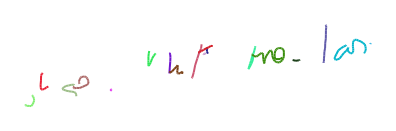

Epoch :  6  - step  100 / 911  - loss  -99.1871109008789  in  6.72905421257019
Epoch :  6  - step  200 / 911  - loss  -76.86907958984375  in  3.5379271507263184
Epoch :  6  - step  300 / 911  - loss  36.25168991088867  in  3.5428264141082764
Epoch :  6  - step  400 / 911  - loss  -83.43749237060547  in  3.532081365585327
Epoch :  6  - step  500 / 911  - loss  -2.1608474254608154  in  3.5529963970184326
Generating sequence ...


FloatProgress(value=0.0, max=300.0)

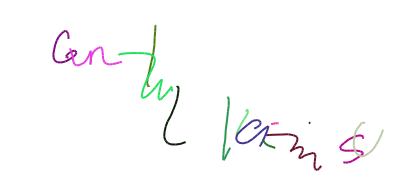

Epoch :  6  - step  600 / 911  - loss  25.04902458190918  in  6.763251304626465
Epoch :  6  - step  700 / 911  - loss  -263.07061767578125  in  3.543673038482666
Epoch :  6  - step  800 / 911  - loss  109.6950912475586  in  3.5446956157684326
Epoch :  6  - step  900 / 911  - loss  -83.72804260253906  in  3.5471277236938477
Epoch :  7  - step  0 / 911  - loss  242.4664306640625  in  0.4049983024597168
Generating sequence ...


FloatProgress(value=0.0, max=300.0)

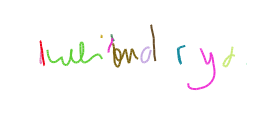

Epoch :  7  - step  100 / 911  - loss  -61.921173095703125  in  6.867343902587891
Epoch :  7  - step  200 / 911  - loss  -227.7129364013672  in  3.5420374870300293
Epoch :  7  - step  300 / 911  - loss  -34.596473693847656  in  3.569577932357788
Epoch :  7  - step  400 / 911  - loss  -152.82098388671875  in  3.5452122688293457
Epoch :  7  - step  500 / 911  - loss  25.16908836364746  in  3.5468647480010986
Generating sequence ...


FloatProgress(value=0.0, max=300.0)

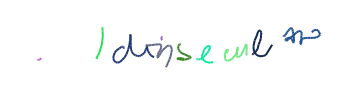

Epoch :  7  - step  600 / 911  - loss  -49.01192855834961  in  6.870987176895142
Epoch :  7  - step  700 / 911  - loss  -154.3878173828125  in  3.5392444133758545
Epoch :  7  - step  800 / 911  - loss  -47.071510314941406  in  3.5459542274475098
Epoch :  7  - step  900 / 911  - loss  -72.3935546875  in  3.542269229888916
Epoch :  8  - step  0 / 911  - loss  150.35800170898438  in  0.40148091316223145
Generating sequence ...


FloatProgress(value=0.0, max=300.0)

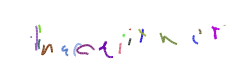

Epoch :  8  - step  100 / 911  - loss  -103.82132720947266  in  6.8970887660980225
Epoch :  8  - step  200 / 911  - loss  45.0210075378418  in  3.5413684844970703
Epoch :  8  - step  300 / 911  - loss  28.788808822631836  in  3.540045976638794
Epoch :  8  - step  400 / 911  - loss  -5.83919095993042  in  3.558302640914917
Epoch :  8  - step  500 / 911  - loss  -72.6404037475586  in  3.547341823577881
Generating sequence ...


FloatProgress(value=0.0, max=300.0)

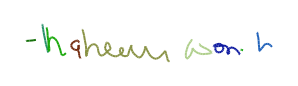

Epoch :  8  - step  600 / 911  - loss  -28.82035255432129  in  6.960362195968628
Epoch :  8  - step  700 / 911  - loss  -134.6367645263672  in  3.5443475246429443
Epoch :  8  - step  800 / 911  - loss  -66.81999969482422  in  3.5468966960906982
Epoch :  8  - step  900 / 911  - loss  -67.97696685791016  in  3.553480386734009
Epoch :  9  - step  0 / 911  - loss  172.3000030517578  in  0.4023740291595459
Generating sequence ...


FloatProgress(value=0.0, max=300.0)

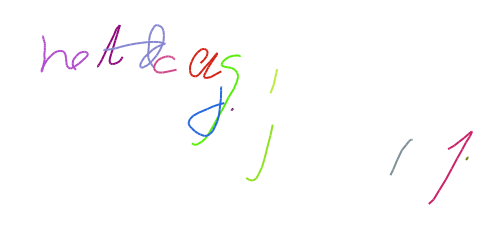

Epoch :  9  - step  100 / 911  - loss  -130.424560546875  in  7.0026538372039795
Epoch :  9  - step  200 / 911  - loss  53.60786056518555  in  3.562411069869995
Epoch :  9  - step  300 / 911  - loss  18.948816299438477  in  3.550962209701538
Epoch :  9  - step  400 / 911  - loss  5.692624092102051  in  3.554029941558838
Epoch :  9  - step  500 / 911  - loss  -77.48413848876953  in  3.538431406021118
Generating sequence ...


FloatProgress(value=0.0, max=300.0)

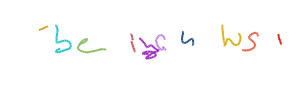

Epoch :  9  - step  600 / 911  - loss  -76.23863983154297  in  7.0053510665893555
Epoch :  9  - step  700 / 911  - loss  11.728471755981445  in  3.5560402870178223
Epoch :  9  - step  800 / 911  - loss  -42.1178092956543  in  3.5415070056915283
Epoch :  9  - step  900 / 911  - loss  -71.66217803955078  in  3.558356523513794


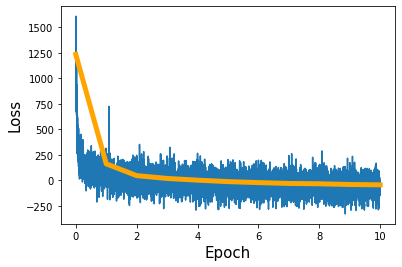

In [7]:
model = HandwritingGenerationModel(hidden_size, n_layers, n_gaussians, dropout)
model, time_batch, loss_batch, time_epoch, loss_epoch = train_network(model, epochs=10, generate=True)

Generating sequence ...


FloatProgress(value=0.0, max=300.0)

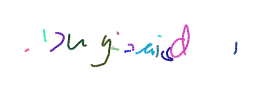

In [8]:
x0 = torch.Tensor([0,0,1]).view(1,1,3)

if use_cuda:
    x0 = x0.cuda()

sequence = model.generate_sequence(x0, sequence_length = 300)
draw_strokes_random_color(sequence, factor=0.5)